In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
epoch_num = 5
sequence_length = 8  # Number of time steps to consider

# Define file and directory names
file_name = '0_61938.csv'
data_dir = 'ohlc_data'
# parent_dir = 'forexPredictor'
# repo = 'Repos_git'
# repo_dir = 'Make_Money_with_Tensorflow_2.0'
# Get the absolute base directory dynamically
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Move up one level

# Construct the full file path in an OS-independent way
# data_path = os.path.join(base_dir, repo, repo_dir, parent_dir, data_dir, file_name)
data_path = os.path.join(base_dir, data_dir, file_name)

# Check if the file exists before using it
if os.path.exists(data_path):
    print(f"✅ File found: {data_path}")
else:
    print(f"❌ Error: File not found at {data_path}")


ucols=['Open', 'High', 'Low', 'Close']
data_main = pd.read_csv(data_path, usecols=ucols)
data_main.reset_index(drop=True, inplace=True)
data_main.head()


✅ File found: D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\0_61938.csv


,Open,High,Low,Close
0,1.20997,1.21089,1.20966,1.20999
1,1.20481,1.20569,1.20479,1.20538
2,1.20537,1.20574,1.20341,1.20553
3,1.20556,1.20689,1.20442,1.20469
4,1.20468,1.20599,1.20380,1.20573


In [8]:
def split_time_series(df, chunk_size, step_size):
    """
    Split time series into overlapping chunks.
    """
    chunks = []
    for i in range(0, len(df) - chunk_size + 1, step_size):
        chunk = df.iloc[i:i + chunk_size][['Open', 'High', 'Low', 'Close']].values
        chunks.append(chunk)
    return np.array(chunks)



In [25]:
chunk_sz = 24*5
step_sz = 24*5
# Example usage
chunks = split_time_series(data_main, chunk_size=chunk_sz, step_size=step_sz)


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import math

def plot_chunks(chunks, num_plots=12):
    """
    Plot the most recent time series chunks in a grid (max 3 plots per row).

    Parameters:
    - chunks: np.array of shape (n_chunks, chunk_size, 4)
    - num_plots: int, number of most recent chunks to plot
    """
    num_plots = min(num_plots, len(chunks))
    cols = min(3, num_plots)
    rows = math.ceil(num_plots / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
    fig.suptitle('Most Recent OHLC Time Series Chunks', fontsize=16)
    
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    else:
        axes = np.array(axes).reshape(-1)

    for idx in range(num_plots):
        ax = axes[idx]
        chunk = chunks[idx]  # Pick the last `num_plots` chunks
        ax.plot(chunk[:, 0], label='Open', color='blue')
        ax.plot(chunk[:, 1], label='High', color='green')
        ax.plot(chunk[:, 2], label='Low', color='red')
        ax.plot(chunk[:, 3], label='Close', color='black')
        ax.set_title(f'Chunk {-num_plots + idx + len(chunks)}')
        ax.grid(True)

        if idx == 0:
            ax.legend()

    for idx in range(num_plots, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


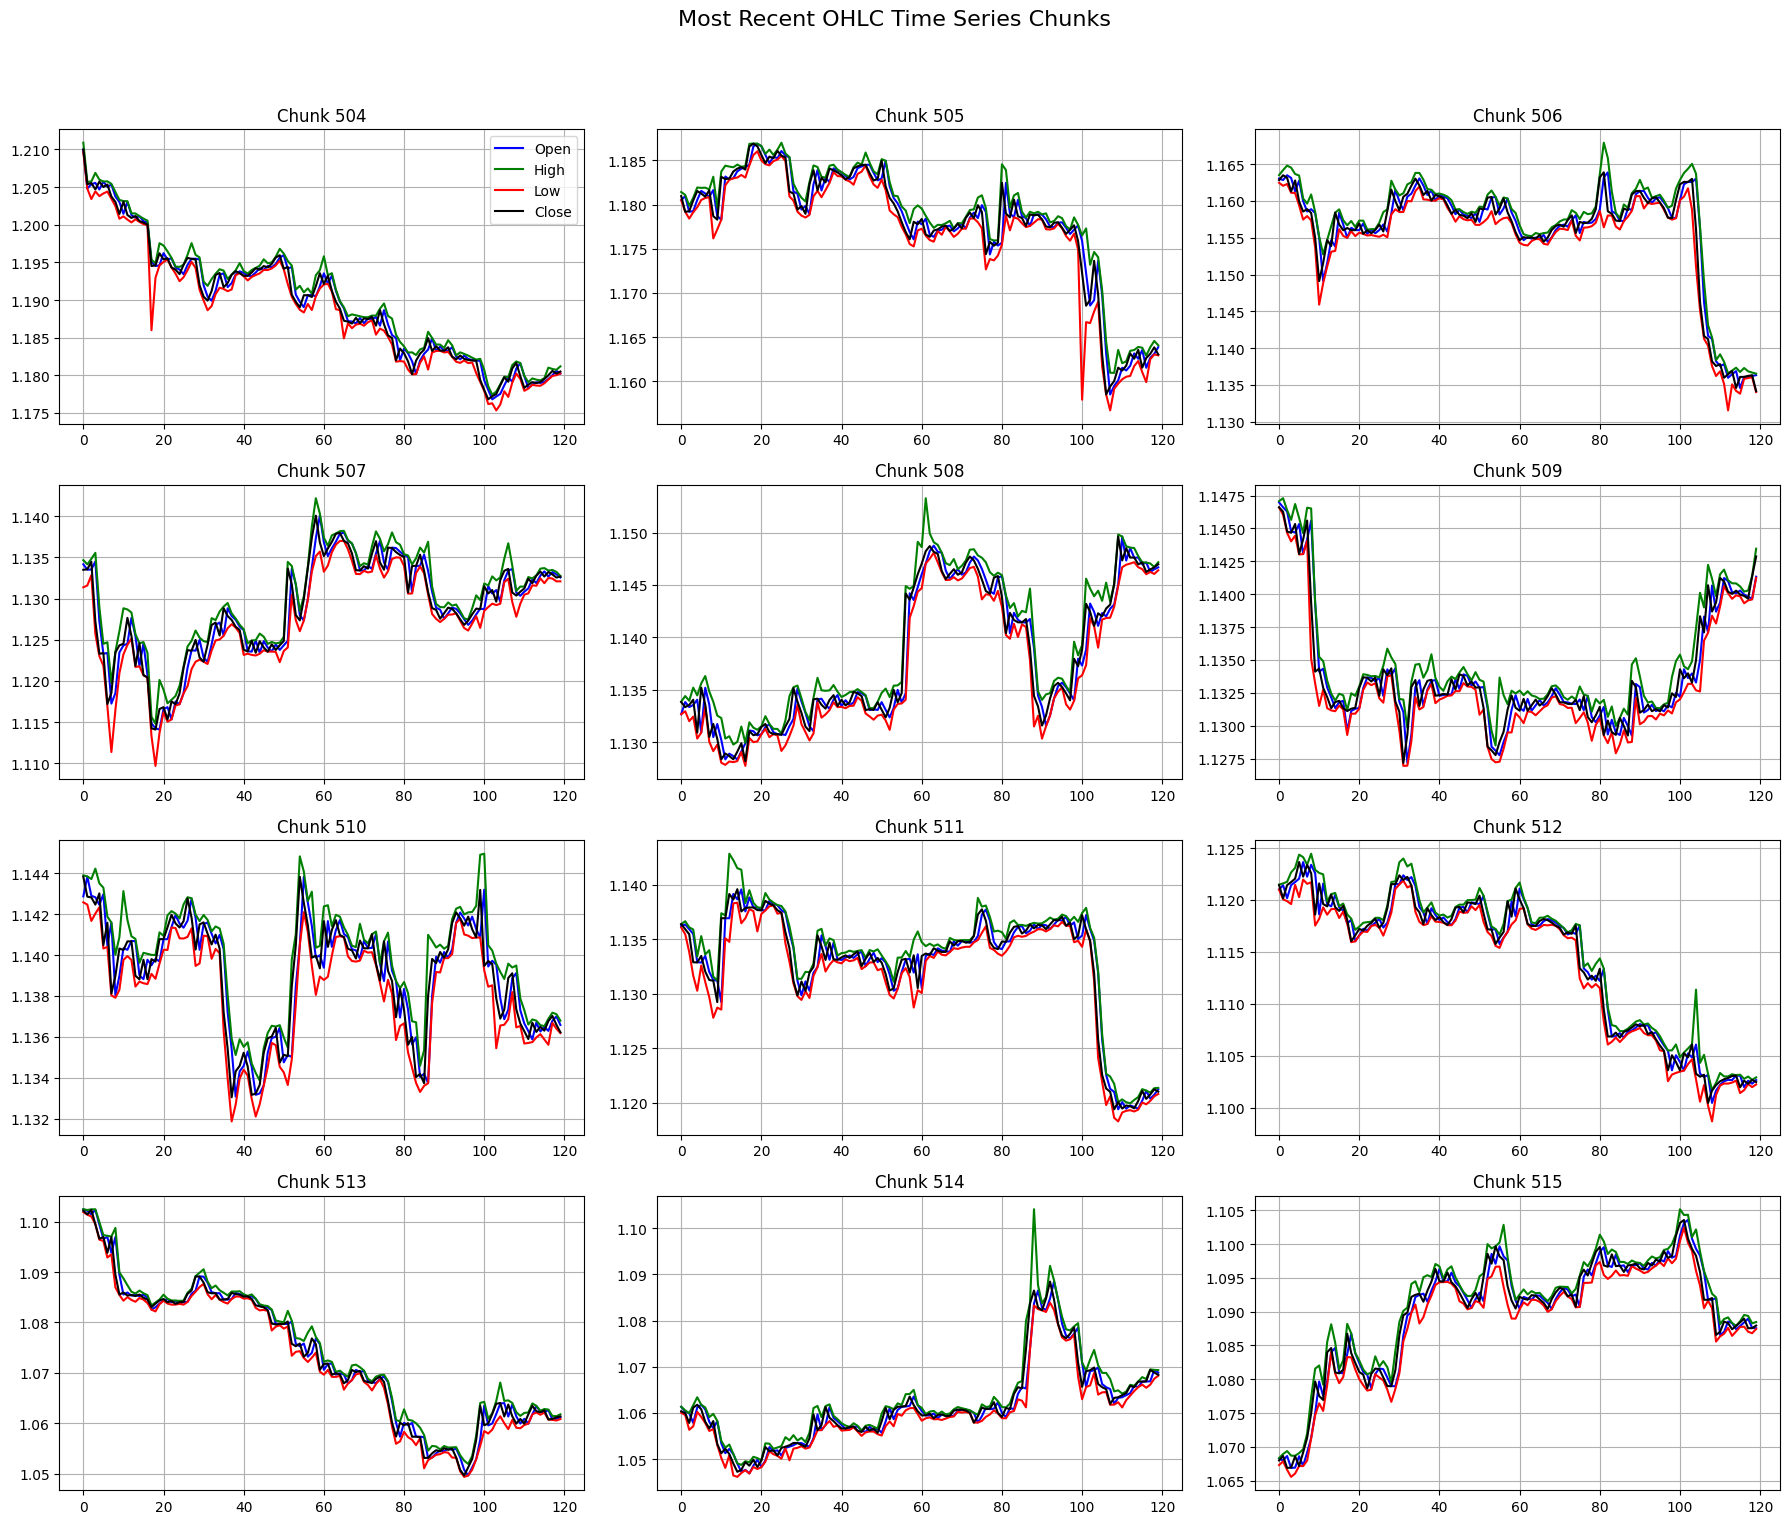

In [30]:
plot_chunks(chunks, 12)

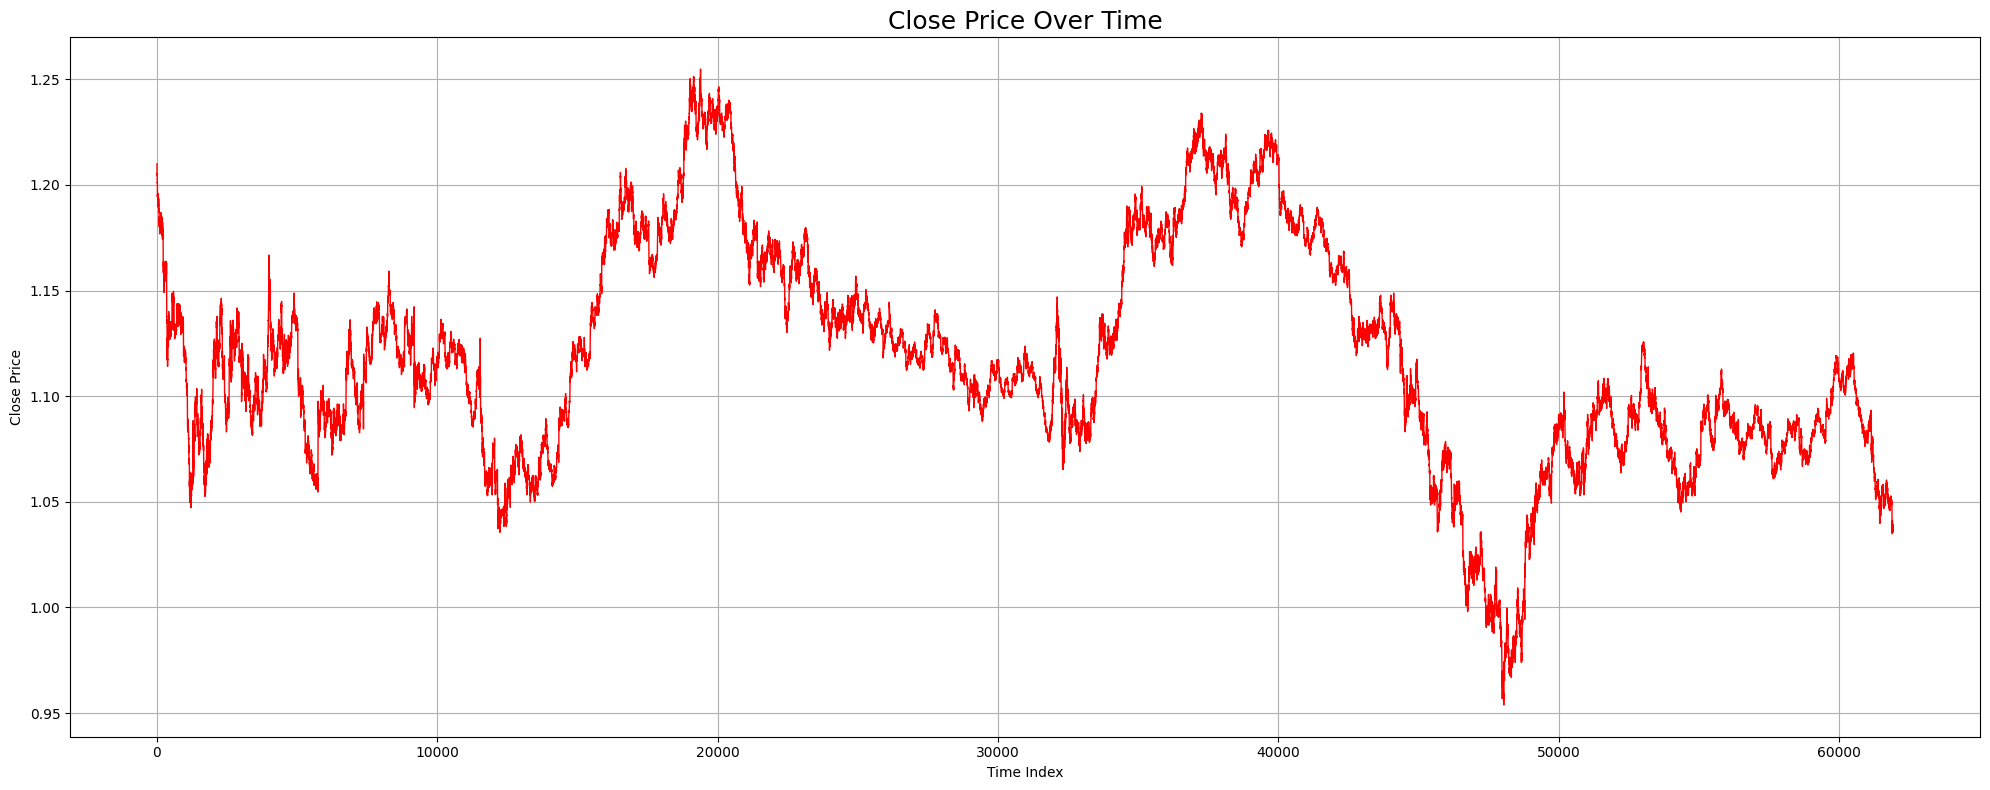

In [77]:
plt.figure(figsize=(20, 8))
data_main['Close'].plot(color='red', linewidth=1)
plt.title('Close Price Over Time', fontsize=18)
plt.xlabel('Time Index')
plt.ylabel('Close Price')
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector

def build_autoencoder(seq_length, feature_dim):
    inputs = Input(shape=(seq_length, feature_dim))
    encoded = LSTM(64)(inputs)
    bottleneck = RepeatVector(seq_length)(encoded)
    decoded = LSTM(feature_dim, return_sequences=True)(bottleneck)
    
    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

seq_length, feature_dim = chunks.shape[1], chunks.shape[2]
autoencoder, encoder = build_autoencoder(seq_length, feature_dim)


In [51]:
# Train autoencoder
autoencoder.fit(chunks, chunks, epochs=50, batch_size=64, verbose=1)


Epoch 1/50
9/9 [==============================] - 3s 60ms/step - loss: 1.0026
Epoch 2/50
9/9 [==============================] - 1s 58ms/step - loss: 0.4948
Epoch 3/50
9/9 [==============================] - 0s 50ms/step - loss: 0.2301
Epoch 4/50
9/9 [==============================] - 0s 52ms/step - loss: 0.0970
Epoch 5/50
9/9 [==============================] - 0s 52ms/step - loss: 0.0494
Epoch 6/50
9/9 [==============================] - 0s 50ms/step - loss: 0.0349
Epoch 7/50
9/9 [==============================] - 0s 53ms/step - loss: 0.0292
Epoch 8/50
9/9 [==============================] - 0s 52ms/step - loss: 0.0263
Epoch 9/50
9/9 [==============================] - 0s 50ms/step - loss: 0.0247
Epoch 10/50
9/9 [==============================] - 0s 47ms/step - loss: 0.0236
Epoch 11/50
9/9 [==============================] - 0s 51ms/step - loss: 0.0229
Epoch 12/50
9/9 [==============================] - 0s 49ms/step - loss: 0.0223
Epoch 13/50
9/9 [==============================] - 0s 50ms/st

In [52]:
# Extract latent features
features = encoder.predict(chunks)

17/17 [==============================] - 0s 8ms/step


In [53]:
# Use KMeans or DBSCAN to cluster the latent features.
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Cluster into 3 groups (Buy/Sell/Hold)
kmeans = KMeans(n_clusters=3, random_state=0)
cluster_labels = kmeans.fit_predict(features_scaled)


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [62]:
# Map Clusters to Signals
# Map the clusters to actual trade signals by analyzing their average future returns:
def map_clusters_to_signals(cluster_labels, df, chunk_size, step_size, window=5):
    """
    Map cluster labels (from chunks) to future returns and derive Buy/Sell/Hold signals.
    
    Parameters:
    - cluster_labels: Array of cluster labels (same length as number of chunks)
    - df: Original DataFrame with 'Close' column
    - chunk_size: Length of each chunk
    - step_size: Step used during chunking
    - window: Number of days ahead to calculate future return

    Returns:
    - signal_mapping: dict mapping cluster -> signal {-1, 0, 1}
    """
    close_prices = df['Close'].values
    future_returns = []

    # Use end index of each chunk to compute future return
    for i in range(0, len(df) - chunk_size - window + 1, step_size):
        end_idx = i + chunk_size - 1
        if end_idx + window < len(close_prices):
            ret = (close_prices[end_idx + window] / close_prices[end_idx]) - 1
            future_returns.append(ret)

    # Align lengths
    future_returns = np.array(future_returns)
    cluster_labels = np.array(cluster_labels[:len(future_returns)])

    # Group and compute mean return per cluster
    grouped_returns = pd.DataFrame({
        'cluster': cluster_labels,
        'return': future_returns
    })
    mean_returns = grouped_returns.groupby('cluster')['return'].mean()

    # Map to signal: rank → {-1: sell, 0: hold, 1: buy}
    signal_map = mean_returns.rank().astype(int) - 2  # maps lowest to -1, mid to 0, highest to 1
    return signal_map.to_dict()



In [67]:
signal_mapping = map_clusters_to_signals(cluster_labels, data_main, chunk_sz, step_sz)
signals = [signal_mapping[c] for c in cluster_labels]

In [71]:
def plot_full_series_with_signals(df, chunk_size, step_size, signals):
    """
    Plot the full Close price series and overlay Buy/Hold/Sell signals at chunk endpoints.
    """
    close_prices = df['Close'].values
    time_index = np.arange(len(close_prices))

    signal_x = []
    signal_y = []
    signal_type = []

    for i, signal in zip(range(0, len(df) - chunk_size + 1, step_size), signals):
        chunk_end_idx = i + chunk_size - 1
        if chunk_end_idx < len(close_prices):
            signal_x.append(chunk_end_idx)
            signal_y.append(close_prices[chunk_end_idx])
            signal_type.append(signal)

    # Plot
    plt.figure(figsize=(16, 6))
    plt.plot(time_index, close_prices, label='Close', color='gray')

    for x, y, sig in zip(signal_x, signal_y, signal_type):
        if sig == 1:
            plt.scatter(x, y, color='blue', label='Buy' if 'Buy' not in plt.gca().get_legend_handles_labels()[1] else "", s=40)
        elif sig == 0:
            plt.scatter(x, y, color='black', label='Hold' if 'Hold' not in plt.gca().get_legend_handles_labels()[1] else "", s=40)
        elif sig == -1:
            plt.scatter(x, y, color='red', label='Sell' if 'Sell' not in plt.gca().get_legend_handles_labels()[1] else "", s=40)

    plt.title('Full Time Series with Buy/Hold/Sell Signals')
    plt.xlabel('Time Index')
    plt.ylabel('Close Price')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


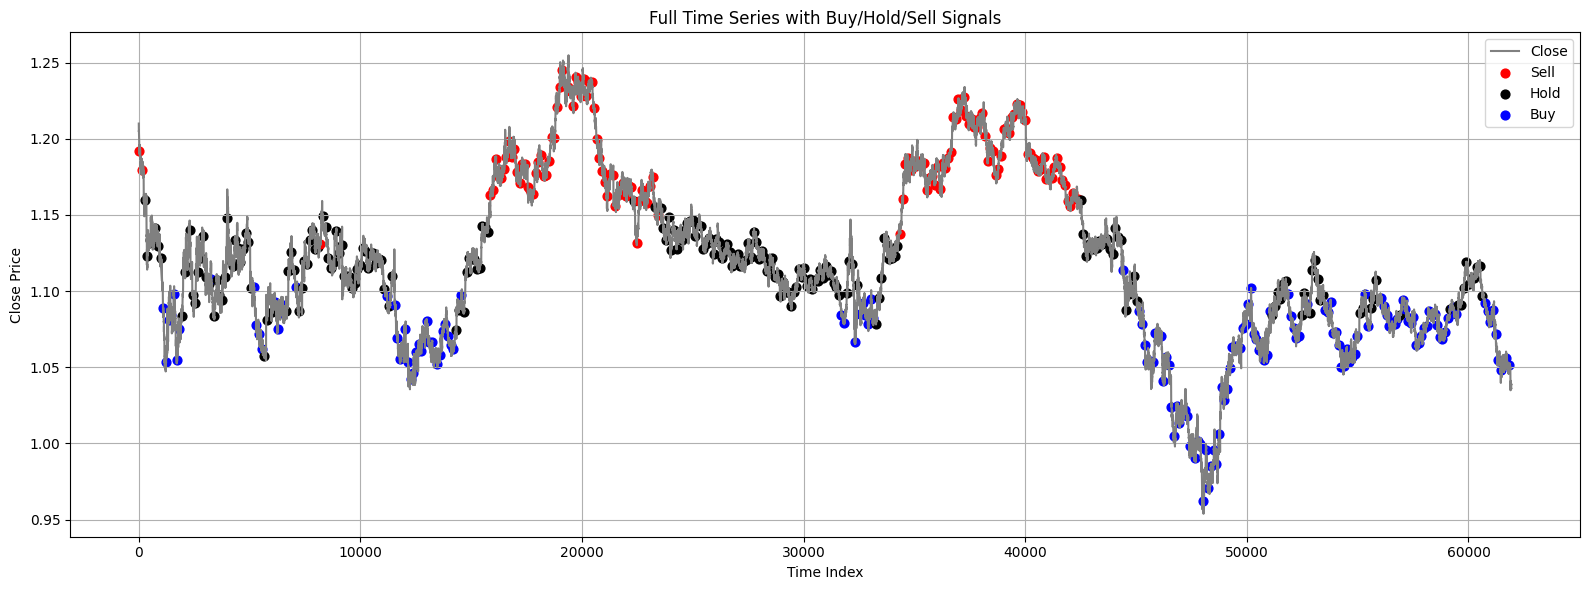

In [74]:
plot_full_series_with_signals(data_main, chunk_size=30, step_size=step_sz, signals=signals)
